# 4.3 - Train a model for each dataset category, comparing it to random data

In [1]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter2
from trainer import Trainer, TrainResults
from batch_encoder import Dataset, one_hot
from block_sampler import count_sectors, BlockSamplerByFile, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder, xs_encoder_one_hot
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.3-randomness'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()
rawtset, rawvset = rawset.rnd_split_fraction_by_category(0.5)

In [4]:
def CM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = MaxPooling1D(pool_size=481, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [5]:
class CatSampler:
    def __init__(self, model, blksampler, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))
        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks)
            predict = np.argmax(predict, axis=-1)
            blks = [x for x,y in zip(blks, predict) if y == self.cat]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.blksampler.dataset.categories[self.cat])


In [6]:
class ThrSampler:
    def __init__(self, model, blksampler, threshold, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.threshold = threshold
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))

        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks, use_multiprocessing=False, workers=0)
            predict = predict[:,0]-predict[:,1]
            blks = [x for x,y in zip(blks, predict) if y > self.threshold]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.cat)


In [7]:
steps_per_epoch=28
patience=10

In [8]:
import models
from block_sampler import BlockSamplerByCategory
from batch_encoder import BatchEncoder
from collections import namedtuple
import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

TrainResults = namedtuple(
    'TrainResults', ['model', 'history', 'metrics', 'elapsed'])

class RandomTrainer:
    def __init__(self,
                 model,
                 xs_encoder='one_hot',
                 validation_steps=steps_per_epoch,
                 steps_per_epoch=steps_per_epoch,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=patience):
        self.model = model
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience

    def train(self, tset, vset, previous_model=None, previous_model2=None):
        tsampler = BlockSamplerByFile(tset)
        if previous_model:
            tsampler = CatSampler(previous_model, tsampler, 0)
        if previous_model2:
            tsampler = CatSampler(previous_model2, tsampler, 0)
        trsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
        tbenc = BatchEncoder(trsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        vsampler = BlockSamplerByFile(vset)
        if previous_model:
            vsampler = CatSampler(previous_model, vsampler, 0)
        if previous_model2:
            vsampler = CatSampler(previous_model2, vsampler, 0)
        vrsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
        vbenc = BatchEncoder(vrsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        return self._train(tbenc,vbenc)

    def _train(self, tbenc, vbenc):
        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            # TensorBoard(
            #     log_dir=os.path.join(log_dir, model.name),
            #     # update_freq=3100,
            # ),
#             LambdaCallback(on_epoch_end = lambda epoch, logs: print(logs['val_categorical_accuracy'])),
        ],
            use_multiprocessing=False,
            workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

In [9]:
def rndgen(block_instance=False):
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        if block_instance:
            yield (rdata, np.array([0,1]*100).reshape(100,2))
        else:
            yield rdata

# Train pass1 models

In [10]:
r = Reporter2(result_dir + "/pass1.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = CM(2, 256)
    print(cat)
    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    
    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass1.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
pptx
val_acc = 0.7342857 struct_acc= 0.503 rnd_acc= 0.93
ppt
val_acc = 0.76785713 struct_acc= 0.583 rnd_acc= 0.977
f
val_acc = 0.995 struct_acc= 0.99 rnd_acc= 1.0
java
val_acc = 0.9992857 struct_acc= 1.0 rnd_acc= 1.0
wp
val_acc = 0.995 struct_acc= 0.988 rnd_acc= 1.0
jpg
val_acc = 0.9021429 struct_acc= 0.862 rnd_acc= 0.957
xls
val_acc = 0.9910714 struct_acc= 0.993 rnd_acc= 1.0
rtf
val_acc = 0.99785715 struct_acc= 0.995 rnd_acc= 1.0
pps
val_acc = 0.76357144 struct_acc= 0.564 rnd_acc= 0.956
hlp
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
html
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
swf
val_acc = 0.68035716 struct_acc= 0.354 rnd_acc= 0.991
png
val_acc = 0.645 struct_acc= 0.33 rnd_acc= 0.965
log
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
xml
val_acc = 0.9982143 struct_acc= 0.999 rnd_acc= 1.0
csv
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
doc
val_acc = 0.9275 struct_acc= 0.

# Load data

In [11]:
data = pd.read_csv(result_dir + '/pass1.tsv', sep='\t')
data['struct_TP'] = data['struct_acc'] - ((1 - data['struct_acc'])*(1 - data['rnd_acc'])/data['rnd_acc'])
data['struct_precision'] = data['struct_TP']/data['struct_acc']
data = data.sort_values('struct_TP')
data

,category,val_acc,struct_acc,rnd_acc,Time,Epochs,struct_TP,struct_precision
20,dwf,0.581786,0.237,0.939,11m30s,13,0.187433,0.790858
12,png,0.645000,0.330,0.965,24m46s,29,0.305699,0.926362
26,gz,0.639286,0.442,0.852,24m08s,25,0.345070,0.780702
11,swf,0.680357,0.354,0.991,18m16s,20,0.348133,0.983427
24,kmz,0.723929,0.431,1.000,13m25s,14,0.431000,1.000000
21,gif,0.714286,0.460,0.990,37m15s,42,0.454545,0.988142
0,pptx,0.734286,0.503,0.930,49m28s,56,0.465591,0.925629
22,pdf,0.744286,0.501,0.990,57m04s,64,0.495960,0.989939
8,pps,0.763571,0.564,0.956,52m16s,58,0.543933,0.964420
1,ppt,0.767857,0.583,0.977,51m41s,58,0.573183,0.983162


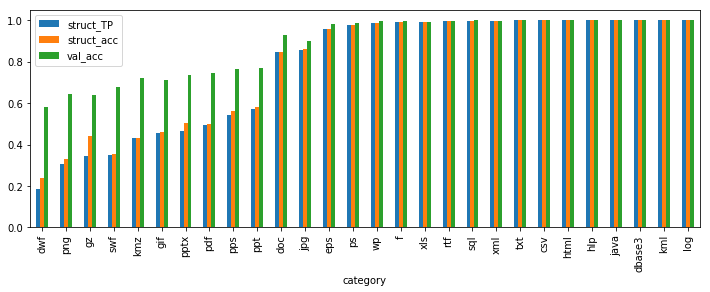

In [12]:
data.plot.bar('category', ['struct_TP', 'struct_acc', 'val_acc'], figsize=(12,4))
plt.show()

In [13]:
data.mean()

val_acc              0.884643
struct_acc           0.786357
rnd_acc              0.983821
Epochs              23.178571
struct_TP            0.777048
struct_precision     0.975909
dtype: float64

In [14]:
1-np.sum(data['struct_TP'])/28

0.22295183454543077

In [15]:
1-(np.sum(data['struct_TP'])+(1-0.22))/28

0.19509469168828786

# Use models to evaluate dataset

In [16]:
if os.path.exists(result_dir + "/evaluate.tsv"):
    os.remove(result_dir + "/evaluate.tsv")
r = Reporter2(result_dir + "/evaluate.tsv")
for cat, vset in by_categoryV.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    struct_TP = struct_acc - (1-struct_acc)*(1-rnd_acc)/rnd_acc
    
    print(cat, struct_acc, rnd_acc, struct_TP )
    r.line(cat=cat, struct_acc=struct_acc, rnd_acc=rnd_acc, struct_TP=struct_TP)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
kml 1.0 1.0 1.0
ppt 0.558 0.985 0.5512690706117155
wp 0.987 1.0 0.9869999885559082
txt 1.0 1.0 1.0
png 0.331 0.95 0.2957894650984998
csv 1.0 1.0 1.0
f 0.99 1.0 0.9900000095367432
dwf 0.243 0.931 0.18689580672678435
swf 0.36 0.985 0.35025383106579516
log 1.0 1.0 1.0
sql 0.999 1.0 0.9990000128746033
pps 0.581 0.948 0.558016852898694
jpg 0.866 0.962 0.8607068590322907
gz 0.429 0.846 0.32505910265420324
pptx 0.545 0.925 0.5081081324898471
eps 0.966 1.0 0.9660000205039978
rtf 0.997 1.0 0.996999979019165
pdf 0.51 0.992 0.506048369410367
xls 0.984 1.0 0.984000027179718
dbase3 1.0 1.0 1.0
gif 0.439 0.986 0.4310344942234576
hlp 1.0 1.0 1.0
kmz 0.428 1.0 0.42800000309944153
java 0.998 1.0 0.9980000257492065
ps 0.98 1.0 0.9800000190734863
doc 0.851 1.0 0.8510000109

# Load evaluation data

In [17]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('struct_TP')
data3

,cat,struct_acc,rnd_acc,struct_TP
7,dwf,0.243,0.931,0.186896
4,png,0.331,0.950,0.295789
13,gz,0.429,0.846,0.325059
8,swf,0.360,0.985,0.350254
22,kmz,0.428,1.000,0.428000
20,gif,0.439,0.986,0.431034
17,pdf,0.510,0.992,0.506048
14,pptx,0.545,0.925,0.508108
1,ppt,0.558,0.985,0.551269
11,pps,0.581,0.948,0.558017


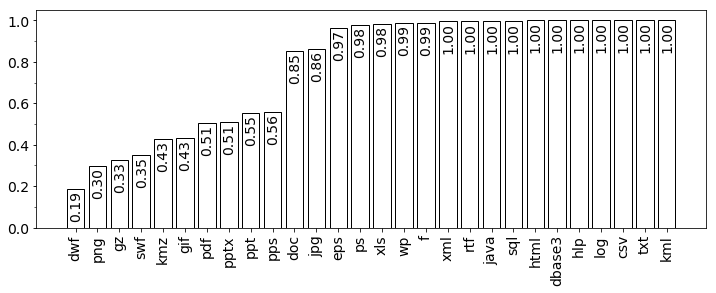

In [18]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [19]:
data3.mean()

struct_acc    0.787071
rnd_acc       0.982500
struct_TP     0.776757
dtype: float64

In [20]:
1-np.sum(data3['struct_TP'])/28

0.2232434974048233

In [21]:
1-(np.sum(data3['struct_TP'])+(1-0.27))/28

0.19717206883339478

# Train pass2 models

In [22]:
if os.path.exists(result_dir + "/pass2.tsv"):
    os.remove(result_dir + "/pass2.tsv")
r = Reporter2(result_dir + "/pass2.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
threshold=0.5
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    previous_model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    model = CM(2, 256)
    print(cat)
    batch_size = 100
    tsampler = BlockSamplerByFile(tset)
    tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10,use_multiprocessing=False,workers=0)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10,use_multiprocessing=False,workers=0)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass2.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

pptx
val_acc = 0.9603571 struct_acc= 0.946 rnd_acc= 1.0
ppt
val_acc = 0.9714286 struct_acc= 0.945 rnd_acc= 1.0
jpg
val_acc = 0.99785715 struct_acc= 0.996 rnd_acc= 0.996
pps
val_acc = 0.98571426 struct_acc= 0.97 rnd_acc= 1.0
swf
val_acc = 0.9775 struct_acc= 0.962 rnd_acc= 1.0
png
val_acc = 0.9917857 struct_acc= 0.98 rnd_acc= 1.0
doc
val_acc = 0.99642855 struct_acc= 0.993 rnd_acc= 1.0
dwf
val_acc = 1.0 struct_acc= 0.999 rnd_acc= 1.0
gif
val_acc = 0.985 struct_acc= 0.973 rnd_acc= 1.0
pdf
val_acc = 0.995 struct_acc= 0.989 rnd_acc= 1.0
kmz
val_acc = 0.99964285 struct_acc= 0.997 rnd_acc= 1.0
gz
val_acc = 0.9992857 struct_acc= 0.998 rnd_acc= 1.0


# Load pass2 data

In [23]:
data2 = pd.read_csv(result_dir + "/pass2.tsv", sep='\t')
data2['struc_precision'] = data2['struct_acc'] - ((1 - data2['struct_acc'])*(1 - data2['rnd_acc'])/data2['rnd_acc'])
data2 = data2.sort_values('struc_precision')
data2

,category,val_acc,struct_acc,rnd_acc,Time,Epochs,struc_precision
1,ppt,0.971429,0.945,1.000,41m15s,30,0.945000
0,pptx,0.960357,0.946,1.000,62m07s,39,0.946000
4,swf,0.977500,0.962,1.000,20m57s,15,0.962000
3,pps,0.985714,0.970,1.000,112m53s,90,0.970000
8,gif,0.985000,0.973,1.000,47m51s,35,0.973000
5,png,0.991786,0.980,1.000,51m08s,31,0.980000
9,pdf,0.995000,0.989,1.000,53m49s,44,0.989000
6,doc,0.996429,0.993,1.000,11m45s,11,0.993000
2,jpg,0.997857,0.996,0.996,46m39s,39,0.995984
10,kmz,0.999643,0.997,1.000,30m29s,25,0.997000


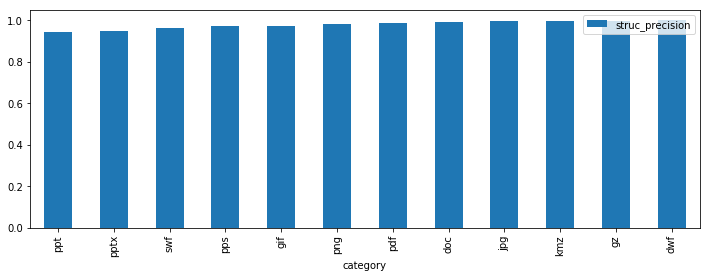

In [24]:
data2.plot.bar('category', ['struc_precision'], figsize=(12,4))
plt.show()

# Use models to evaluate dataset

In [25]:
if os.path.exists(result_dir + "/evaluate.tsv"):
    os.remove(result_dir + "/evaluate.tsv")
r = Reporter2(result_dir + "/evaluate.tsv")
for cat, vset in by_categoryV.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    struct_TP = struct_acc - (1-struct_acc)*(1-rnd_acc)/rnd_acc
    
    print(cat, struct_acc, rnd_acc, struct_TP )
    r.line(cat=cat, struct_acc=struct_acc, rnd_acc=rnd_acc, struct_TP=struct_TP)
r.close()

kml 1.0 1.0 1.0
ppt 0.552 0.983 0.5442522657799662
wp 0.992 1.0 0.9919999837875366
txt 1.0 1.0 1.0
png 0.313 0.959 0.2836287668550936
csv 1.0 1.0 1.0
f 0.99 1.0 0.9900000095367432
dwf 0.241 0.944 0.19597457760890918
swf 0.371 0.995 0.36783919086245825
log 1.0 1.0 1.0
sql 1.0 1.0 1.0
pps 0.594 0.955 0.5748690835445553
jpg 0.855 0.967 0.8500517272156162
gz 0.417 0.861 0.3228803678015017
pptx 0.526 0.932 0.49141632342299507
eps 0.971 1.0 0.9710000157356262
rtf 0.997 1.0 0.996999979019165
pdf 0.506 0.983 0.4974567370621992
xls 0.986 1.0 0.9860000014305115
dbase3 1.0 1.0 1.0
gif 0.438 0.987 0.43059775789909505
hlp 1.0 1.0 1.0
kmz 0.432 0.999 0.43143144997574345
java 0.999 1.0 0.9990000128746033
ps 0.978 1.0 0.9779999852180481
doc 0.856 1.0 0.8560000061988831
html 1.0 1.0 1.0
xml 0.998 1.0 0.9980000257492065


# Load evaluation data

In [26]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('struct_TP')
data3

,cat,struct_acc,rnd_acc,struct_TP
7,dwf,0.241,0.944,0.195975
4,png,0.313,0.959,0.283629
13,gz,0.417,0.861,0.322880
8,swf,0.371,0.995,0.367839
20,gif,0.438,0.987,0.430598
22,kmz,0.432,0.999,0.431431
14,pptx,0.526,0.932,0.491416
17,pdf,0.506,0.983,0.497457
1,ppt,0.552,0.983,0.544252
11,pps,0.594,0.955,0.574869


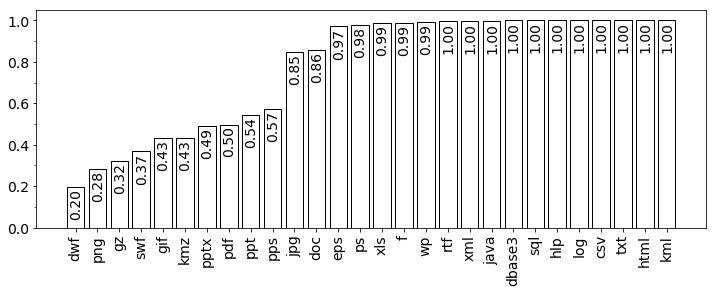

In [27]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [28]:
data3.mean()

struct_acc    0.786143
rnd_acc       0.984464
struct_TP     0.777050
dtype: float64

In [29]:
1-np.sum(data3['struct_TP'])/28

0.2229500618721979

In [30]:
1-(np.sum(data3['struct_TP'])+(1-0.27))/28

0.19687863330076927

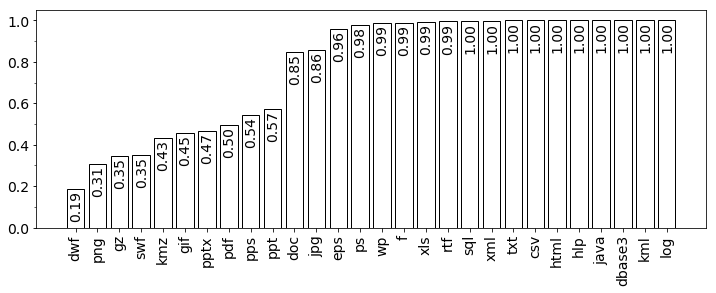

In [31]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data['category'], data['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawvset.ix_to_cat[i]
    v = data.iloc[i,6]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)

# Roc pass1

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
by_category = rawset.by_category()
cat = 'jpg'
dataset = by_category[cat]
dataset.rebuild_categories(categories=['jpg', 'zzz'])

model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

In [34]:
tsampler = BlockSamplerByFile(dataset)
tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat='jpg')

tbenc = BatchEncoder(tsampler,
                     batch_size=1000,
                     xs_encoder='one_hot')
xs, ys = next(iter(tbenc))

In [35]:
datalen = len(xs)
predict = model.predict(xs, batch_size=100)
# predict = np.argmax(predict, axis=-1)

In [36]:
score = predict[:,0]-predict[:,1]
mask = score > 0.9
print(len(score[mask]), len(score))
fpr, tpr, thresholds = roc_curve(ys[:,0][mask], score[mask])
mask = thresholds > 0
fpr[mask], tpr[mask], thresholds[mask]

48 1000


/home/atila.alr/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([0.        , 0.04166667, 0.54166667, 0.66666667, 0.77083333,
        0.8125    , 0.85416667, 0.9375    , 1.        ]),
 array([1.9998908 , 0.9998908 , 0.9543943 , 0.9524551 , 0.9306936 ,
        0.92727476, 0.91845906, 0.9166614 , 0.91004956], dtype=float32))

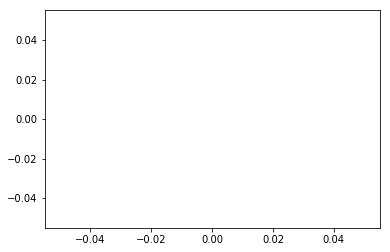

In [37]:
plt.plot(fpr, tpr)

(array([202., 184.,  39.,  52.,  85.,  45.,  68., 149., 106.,  70.]),
 array([-0.79096043, -0.6118753 , -0.4327902 , -0.25370505, -0.07461993,
         0.10446519,  0.28355032,  0.46263543,  0.64172053,  0.82080567,
         0.9998908 ], dtype=float32),
 <a list of 10 Patch objects>)

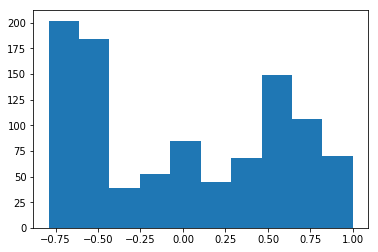

In [38]:
plt.hist(predict[:,0]-predict[:,1])

# Use models to evaluate dataset - using pass2

In [39]:
def rndgen():
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        yield rdata

In [40]:
if os.path.exists(result_dir + "/evaluate2.tsv"):
    os.remove(result_dir + "/evaluate2.tsv")
r = Reporter2(result_dir + "/evaluate2.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model1 = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=1000,
                         xs_encoder='one_hot')
    xs, _ = next(iter(tbenc))
    datalen = len(xs)
    predict = model1.predict(xs, batch_size=100)
    predict = np.argmax(predict, axis=-1)

    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        model2 = tf.keras.models.load_model(result_dir + '/%s_pass2.h5' % cat)
        xs = xs[predict==0]
        datalen = len(xs)
        predict = model2.predict(xs, batch_size=100)
        predict = np.argmax(predict, axis=-1)

    not_random = len(predict[predict==0])/datalen
    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        predict = model2.predict_generator(rndgen(), steps=10)
    else:
        predict = model1.predict_generator(rndgen(), steps=10)
    predict = np.argmax(predict, axis=-1)   
    random = len(predict[predict==1])/(10*100)
    
    true_not_random = not_random - (1-not_random)*(1-random)/random
    
    print(cat, not_random, random, true_not_random )
    r.line(cat=cat, not_random=not_random, random=random, true_not_random=true_not_random)
r.close()

pptx 0.5402504472271914 1.0 0.5402504472271914
f 0.995 1.0 0.995
wp 0.993 1.0 0.993
csv 1.0 1.0 1.0
png 0.4387254901960784 1.0 0.4387254901960784
dwf 0.5344827586206896 1.0 0.5344827586206896
swf 0.6891891891891891 1.0 0.6891891891891891
doc 0.9928825622775801 1.0 0.9928825622775801
txt 1.0 1.0 1.0
pps 0.6293706293706294 1.0 0.6293706293706294
pdf 0.7732142857142857 1.0 0.7732142857142857
rtf 1.0 1.0 1.0
ps 0.979 1.0 0.979
hlp 1.0 1.0 1.0
dbase3 1.0 1.0 1.0
gif 0.5661641541038526 1.0 0.5661641541038526
java 1.0 1.0 1.0
html 1.0 1.0 1.0
sql 0.998 1.0 0.998
gz 0.2510460251046025 1.0 0.2510460251046025
eps 0.981 1.0 0.981
log 1.0 1.0 1.0
xml 0.997 1.0 0.997
jpg 0.8619934282584885 0.996 0.8614391849984824
kml 1.0 1.0 1.0
xls 0.982 1.0 0.982
ppt 0.6979166666666666 1.0 0.6979166666666666
kmz 0.8645038167938931 1.0 0.8645038167938931


# Load evaluation data 2

In [41]:
data4 = pd.read_csv(result_dir + "/evaluate2.tsv", sep='\t')
data4 = data4.sort_values('true_not_random')
data4

,cat,not_random,random,true_not_random
19,gz,0.251046,1.000,0.251046
4,png,0.438725,1.000,0.438725
5,dwf,0.534483,1.000,0.534483
0,pptx,0.540250,1.000,0.540250
15,gif,0.566164,1.000,0.566164
9,pps,0.629371,1.000,0.629371
6,swf,0.689189,1.000,0.689189
26,ppt,0.697917,1.000,0.697917
10,pdf,0.773214,1.000,0.773214
23,jpg,0.861993,0.996,0.861439


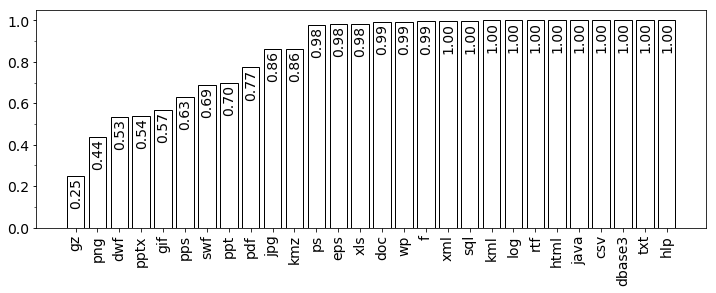

In [42]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data4['cat'], data4['true_not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data4.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [43]:
data4.mean()

not_random         0.848741
random             0.999857
true_not_random    0.848721
dtype: float64

In [44]:
1-np.sum(data4['true_not_random'])/28

0.1512790996334592

In [45]:
1-(np.sum(data4['true_not_random'])+(1-0.62))/28

0.13770767106203063